Loading and preprocessing data...
Reading CSV file...
Filtering invalid entries and removing label 4...
Sampling 50.0% of data...
Calculating features...



Class distribution:
label_majority
1.0    1619
2.0    4876
3.0    1053
Name: count, dtype: int64

Preparing features and target...
Splitting data...
Training model...
Making predictions...

Classification Report:
              precision    recall  f1-score   support

         1.0       0.70      0.72      0.71       324
         2.0       0.89      0.86      0.87       975
         3.0       0.75      0.81      0.78       211

    accuracy                           0.82      1510
   macro avg       0.78      0.80      0.79      1510
weighted avg       0.83      0.82      0.82      1510



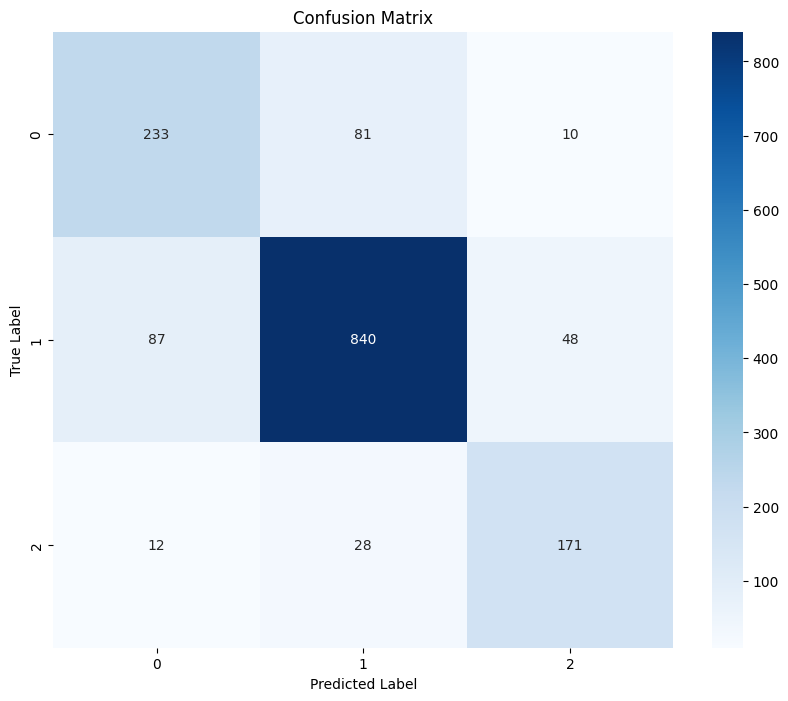


Model saved as: models/new_model_11.joblib
Scaler saved as: models/new_scaler_11.joblib
Selected features saved as: models/selected_features_11.joblib


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as imbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime
import os
import gc

def safe_divide(a, b):
    """Safely divide two pandas series or numpy arrays."""
    a = a.astype(np.float64)
    b = b.astype(np.float64)
    return np.divide(a, b, out=np.zeros_like(a, dtype=np.float64), where=b!=0)

def calculate_features(data):
    """Calculate advanced geometric and topological features from the input data."""
    data = data.copy()
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data[numeric_columns] = data[numeric_columns].astype(np.float64)
    
    # Basic features
    features_to_calculate = [
        ('volume_to_surface_ratio', 'volume', 'surface_area'),
        ('edge_to_face_ratio', 'num_edges', 'num_faces'),
        ('average_face_area', 'surface_area', 'num_faces'),
        ('edge_complexity', 'num_edges', 'num_faces'),
        ('surface_complexity', 'num_unique_normals', 'num_faces'),
        ('thickness_complexity', 'wall_thickness', 'num_faces')
    ]
    
    for new_feat, num, denom in features_to_calculate:
        data[new_feat] = safe_divide(data[num].values, data[denom].values)
    
    # Edge length
    data['average_edge_length'] = safe_divide(
        data[['x_dim', 'y_dim', 'z_dim']].sum(axis=1).values,
        data['num_edges'].values
    )
    
    # Shape factor
    volume_pow = np.power(data['volume'].values, 2/3)
    data['shape_factor'] = safe_divide(data['surface_area'].values, volume_pow)
    
    # Ratios
    for prefix, columns in [
        ('edge', ['num_line_edges', 'num_circle_edges', 'num_ellipse_edges', 'num_bsplinecurve_edges']),
        ('surface', ['num_plane_surfaces', 'num_cylinder_surfaces', 'num_cone_surfaces', 
                    'num_sphere_surfaces', 'num_torus_surfaces', 'num_bspline_surfaces'])
    ]:
        total = data[columns].sum(axis=1).values
        for col in columns:
            data[f'{col}_ratio'] = safe_divide(data[col].values, total)
    
    # Aspect ratios
    data['aspect_ratio_xy'] = safe_divide(data['x_dim'].values, data['y_dim'].values)
    data['aspect_ratio_xz'] = safe_divide(data['x_dim'].values, data['z_dim'].values)
    data['aspect_ratio_yz'] = safe_divide(data['y_dim'].values, data['z_dim'].values)
    
    # Volume ratios
    xyz_product = data['x_dim'].values * data['y_dim'].values * data['z_dim'].values
    data['volume_to_xyz'] = safe_divide(data['volume'].values, xyz_product)
    data['surface_to_xyz'] = safe_divide(data['surface_area'].values, xyz_product)
    
    # Center mass distance
    center_cols = ['x_center_mass_relative', 'y_center_mass_relative', 'z_center_mass_relative']
    center_mass_coords = data[center_cols].values - 0.5
    data['center_mass_distance'] = np.linalg.norm(center_mass_coords, axis=1)
    
    # Log transforms
    for col in ['volume', 'surface_area', 'num_faces', 'num_edges']:
        min_positive = max(data[col].min(), 1e-10)
        data[f'log_{col}'] = np.log1p(data[col].clip(lower=min_positive))
    
    # Complexity score
    complexity_cols = ['edge_complexity', 'surface_complexity', 'thickness_complexity']
    data['overall_complexity'] = data[complexity_cols].clip(lower=0).mean(axis=1)
    
    # Clean up
    data = data.replace([np.inf, -np.inf], 0).fillna(0)
    
    return data

def load_and_preprocess_data(file_path, sample_size=None):
    """Load and preprocess the data with optional downsampling."""
    print("Reading CSV file...")
    data = pd.read_csv(file_path)
    
    print("Filtering invalid entries and removing label 4...")
    mask = (data['volume'] > 0) & (data['surface_area'] > 0) & (data['label_majority'] != 4)
    data = data[mask].copy()
    
    if 'filename' in data.columns:
        data = data.drop(columns=['filename'])
    
    if sample_size is not None and sample_size < 1.0:
        print(f"Sampling {sample_size*100}% of data...")
        # Stratified sampling
        data = data.groupby('label_majority').apply(
            lambda x: x.sample(frac=sample_size, random_state=42)
        ).reset_index(drop=True)
    
    print("Calculating features...")
    data = calculate_features(data)
    
    print("\nClass distribution:")
    print(data['label_majority'].value_counts().sort_index())
    
    return data

def train_model(X_train, y_train, random_state=42):
    """Train the model with custom SMOTE parameters."""
    n_samples = len(X_train)
    
    # Adjust k_neighbors based on class sizes
    k_neighbors = min(5, n_samples // 100)
    
    pipeline = imbPipeline([
        ('scaler', StandardScaler()),
        ('smotetomek', SMOTETomek(
            sampling_strategy='auto',
            smote=SMOTE(k_neighbors=k_neighbors, random_state=random_state),
            random_state=random_state
        )),
        ('classifier', RandomForestClassifier(
            n_estimators=100,
            random_state=random_state,
            n_jobs=-1  # Use all cores
        ))
    ])
    
    pipeline.fit(X_train, y_train)
    return pipeline

def save_model_components(pipeline, le, X_train, version="11"):
    """
    Save the trained model components separately with specified version number:
    - Random Forest model
    - Scaler
    - Selected features
    """
    # Create directory if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    # Extract components from pipeline
    rf_model = pipeline.named_steps['classifier']
    scaler = pipeline.named_steps['scaler']
    
    # Get feature names
    selected_features = list(X_train.columns)
    
    # Prepare filenames with specified version
    model_filename = f'models/new_model_{version}.joblib'
    scaler_filename = f'models/new_scaler_{version}.joblib'
    features_filename = f'models/selected_features_{version}.joblib'
    
    # Save components
    joblib.dump(rf_model, model_filename)
    joblib.dump(scaler, scaler_filename)
    joblib.dump(selected_features, features_filename)
    
    print(f"\nModel saved as: {model_filename}")
    print(f"Scaler saved as: {scaler_filename}")
    print(f"Selected features saved as: {features_filename}")

def main():
    # Set your file path here
    file_path = r"C:\Users\meh91075\Downloads\features_newWallthickness_16092024.csv"
    
    # Optional: Use a smaller sample size for development/testing
    # Set to None or 1.0 to use full dataset
    SAMPLE_SIZE = 0.5  # Use 50% of data
    
    print("Loading and preprocessing data...")
    df = load_and_preprocess_data(file_path, sample_size=SAMPLE_SIZE)
    
    print("\nPreparing features and target...")
    X = df.drop(columns=['label_majority'])
    y = df['label_majority']
    
    # Clean up memory
    del df
    gc.collect()
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    # Clean up memory
    del X
    gc.collect()
    
    print("Training model...")
    pipeline = train_model(X_train, y_train)
    
    print("Making predictions...")
    y_pred = pipeline.predict(X_test)
    
    y_test_original = le.inverse_transform(y_test)
    y_pred_original = le.inverse_transform(y_pred)
    
    print("\nClassification Report:")
    print(classification_report(y_test_original, y_pred_original))
    
    cm = confusion_matrix(y_test_original, y_pred_original)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Save model components separately with version number
    save_model_components(pipeline, le, X_train, version="11")

if __name__ == "__main__":
    main()